# 일반 네트워크의 문제점

- 네트워크가 깊어지면(레이어의 수가 증가하면) 그레디언트가 소실되거나 폭발하는 문제가 발생함
- 이를 해결하기 위해서 skip connection 추가 

# 기존 망과 Residual Block의 차이점

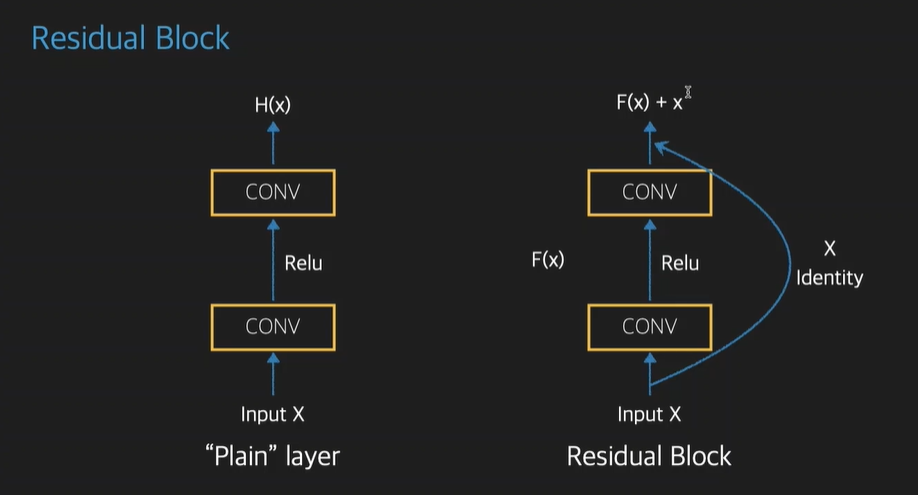

### -> 입력값을 출력값에 더해줄 수 있도록 **지름길**을 하나 만들어줌 

# ResNet 특징
 - 신호 표현을 직접 학습하는 대신 잔류(residual) 표현 함수를 학습
 - 이전 레이어에서 다음 레이어로의 입력을 맞추기 위해 입력의 수정 없이 스킵 연결(skip connection)을 도입
 - 스킵 연결은 더 깊은 네트워크를 가질 수 있게 도와줌
 - layer의 개수에 따라 여러 버전으로 나뉨

# ResNet

## 모델 블록


In [2]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Conv2d

In [3]:
# 컨볼루션 2d
def conv3x3(in_channels, out_channels, stride=1): # 모든 커널 사이즈가 3으로 fix되어 있음
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

## Residual block

In [4]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x) # 컨볼루션 1
        out = self.bn1(out) # batch normalization1
        out = self.relu(out) # 활성함수 relu
        out = self.conv2(out) # 컨볼루션 2
        out = self.bn2(out) # batch normalization2
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
        # 위의 Residual 이미지 참고  

## ResNet

In [5]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1) # flatten 
        out = self.fc(out)
        return out

## 모델 학습

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

cuda


In [7]:
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader 생성
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [8]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device) # layer들을 두개 두개 두개씩 설정하겠다 선언

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # momentum을 주면 학습이 더 잘됨
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
def train_model(model, criterion, dataloaders, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders)
            epoch_acc = running_corrects.double() / len(dataloaders)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [10]:
model_ft = train_model(model, criterion, train_loader, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 185.2020 Acc: 31.1580
val Loss: 166.6267 Acc: 37.2100

Epoch 1/24
----------
train Loss: 153.6830 Acc: 42.8920
val Loss: 144.8347 Acc: 46.7060

Epoch 2/24
----------
train Loss: 136.3123 Acc: 50.2900
val Loss: 128.4182 Acc: 53.1820

Epoch 3/24
----------
train Loss: 123.4119 Acc: 55.2620
val Loss: 124.7653 Acc: 54.4320

Epoch 4/24
----------
train Loss: 112.7001 Acc: 59.3840
val Loss: 110.6201 Acc: 60.2760

Epoch 5/24
----------
train Loss: 104.1475 Acc: 62.9160
val Loss: 128.7012 Acc: 53.1540

Epoch 6/24
----------
train Loss: 97.4002 Acc: 65.3300
val Loss: 104.5177 Acc: 62.4680

Epoch 7/24
----------
train Loss: 88.7810 Acc: 68.6180
val Loss: 86.0737 Acc: 69.6260

Epoch 8/24
----------
train Loss: 87.6293 Acc: 69.1600
val Loss: 85.0172 Acc: 69.8340

Epoch 9/24
----------
train Loss: 86.8609 Acc: 69.2700
val Loss: 84.2493 Acc: 70.1880

Epoch 10/24
----------
train Loss: 85.6543 Acc: 69.7980
val Loss: 83.8483 Acc: 70.3600

Epoch 11/24
----------
train 

### => 최고의 정확도는 71%
---
# 모델 검증

In [12]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # 예측한 값과 라벨 값이 동일한 경우를 활용해서 정확도 계산 

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 70.88 %
